**Assignment 4b (5) Part 1**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emcee

Borrowing our functions from the previous set, with minor modifications to make them logs and with one new function for creating the coin toss data set outside of the probability function:

Log of formula from Set 4 for uniform prior coin toss:

$$ ln \big( prob(H \ \vert \ D, \ I) = ln \big[ \frac{n!  \ H^h (1-H)^{n-h}}{h!(n-h)!} \big) \big] \\ = ln( \ n! \ ) + h \  ln (H) + (n-h) \ ln (1-H) - ln ( \ h! \ ) - ln ([n-h]!) \\ = \sum_{n^* = 2}^n ln (n^*) - \sum_{h^* = 2}^h ln (h^*) - \sum_{j = 2}^{n-h} ln (j) + (n-h) \ ln (1-H) + h \  ln (H) $$

Log of formula from Set 4 for gaussian prior coin toss is the same but with the additional term:

$$ ln \big( Exp \big[-\frac{1}{2} \big( \frac{H-\mu}{\sigma} \big)^2 \big] \big) = -\frac{1}{2} \big( \frac{H-\mu}{\sigma} \big)^2$$



In [2]:
def coinset(n, trueH):
    
    h = np.random.binomial(n,trueH)
    
    return(n,h)


def logfac(N):
    
    inputs = np.arange(2, N+1, 1)
    vals = np.log(inputs)
    lf = np.sum(vals)
    
    return(lf)

def logucp(H, n, h): #uniform case
    
    if H <= 0 or H >= 1:
        return(-np.inf)
    
    else:
        factorials = logfac(n) -logfac(h) - logfac(n-h)
        exponentials = h * np.log(H) + (n-h) * np.log(1-H)
    
        logprob = factorials + exponentials
    
        return(logprob)
    
    
def loggcp(H, n, h, u, s): #gaussian case
    
    if H <= 0 or H >= 1:
        return(-np.inf)
    
    else:
        factorials = logfac(n) -logfac(h) - logfac(n-h)
        exponentials = h * np.log(H) + (n-h) * np.log(1-H)
        prior = -0.5 * ((H-u)/s)**2
    
        logprob = prior + factorials + exponentials
    
        return(logprob)


def lightdata(n, trueA, trueB):
    #theta values drawn from a random uniform distribution between pi/2 and -pi/2
    thetaset = np.random.uniform(-(np.pi) / 2, np.pi / 2, n)

    #translating theta values into x values (in kilometers)
    xdif = trueB * np.tan(thetaset)
    xkset = trueA + xdif
    
    return(xkset)


def loglightprob(abtuple, data): 
    
    A, B = abtuple
    
    if B <= 0:
        
        return(-np.inf)
    
    else:

        quadratic = B**2 + (data - A)**2

        logdat = np.log(quadratic)
    
        n = len(data)
    
        summation = np.sum(logdat) * (-1)
    
        L = n * (np.log(B) + np.log(np.pi)) + summation
    
        return(L)

In [3]:
ctn,cth = coinset(100,0.5)

walkstest = 50
argstest = (ctn,cth)
inst8test = [[np.random.random()] for i in range(walkstest)]

In [4]:
basetest = emcee.EnsembleSampler(walkstest, 1, logucp, args = argstest)
tupletest = basetest.run_mcmc(inst8test,100)
basetest.reset()
dontprint = basetest.run_mcmc(inst8test,10000)

In [5]:
smpltest = basetest.get_chain(flat=True)
plt.hist(smpltest[:, 0], 500, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [6]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(basetest.acceptance_fraction)))

Mean acceptance fraction: 0.806


In [7]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(basetest.get_autocorr_time())
    )
)

Mean autocorrelation time: 28.290 steps


Seems like our procedure works, seems like the number of steps to convergence isn't too ridiculous, and seems like we're accepting a lot of the values, so that's nice :)

Time to make this into a function!

In [8]:
def uctMC(walks, ctn, cth, steps):
    
    argstup = (ctn,cth)
    init = [[np.random.random()] for i in range(walks)]
    
    base = emcee.EnsembleSampler(walks, 1, logucp, args = argstup)
    sample1 = base.run_mcmc(init, 100)
    base.reset()
    base.run_mcmc(init, steps)
    
    sample = base.get_chain(flat=True)
    plt.hist(sample[:, 0], 500, color="k", histtype="step")
    plt.xlabel("H")
    plt.ylabel("Probability")
    plt.gca().set_yticks([]);
    plt.title("Uniform Prior Coin Toss, Walks = " + str(walks) + ", steps = " + str(steps))

Now that we have a function, we can just vary the number of walks by changing that parameter and running a cell. Below, I used 1000 steps and the same data set (ctn, cth) for each run, but changed the walks values to these values (10, 25, 50, 100).

In [9]:
uctMC(10, ctn, cth, 1000)

In [10]:
uctMC(25, ctn, cth, 1000)

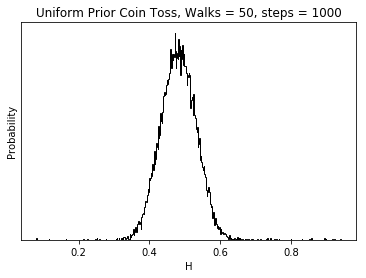

In [11]:
uctMC(50, ctn, cth, 1000)

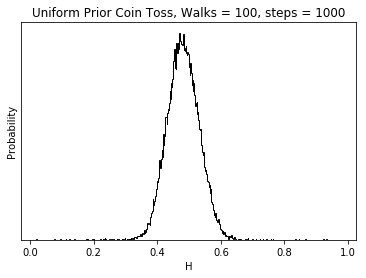

In [12]:
uctMC(100, ctn, cth, 1000)

Likewise, I changed the number of steps while keeping the number of walkers (50) and the data set (ctn, cth) the same for each run. The steps values plotted below are: (10, 50, 100, 500, 1000).  

Note: steps = 1000, walks = 50 graph is above, hence why there's such a big gap in steps between the last two values.

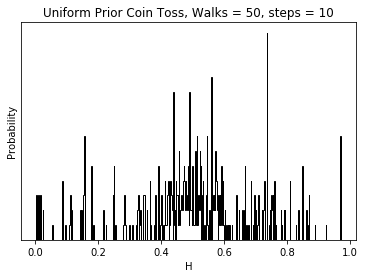

In [13]:
uctMC(50, ctn, cth, 10)

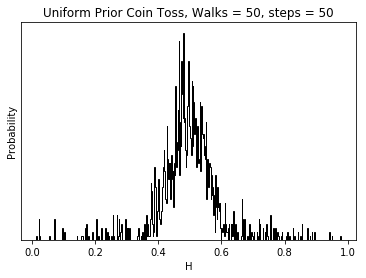

In [14]:
uctMC(50, ctn, cth, 50)

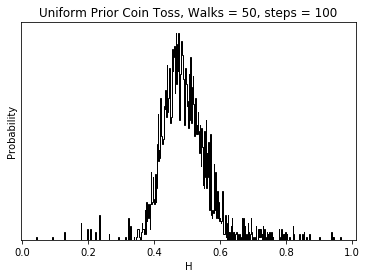

In [15]:
uctMC(50, ctn, cth, 100)

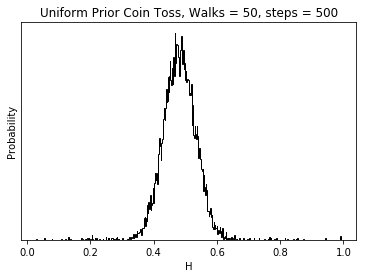

In [16]:
uctMC(50, ctn, cth, 500)

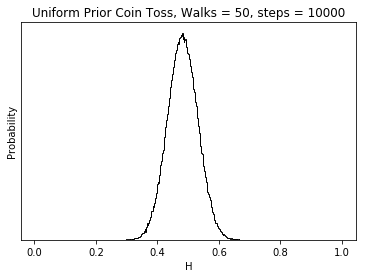

In [17]:
uctMC(50, ctn, cth, 10000)

Now for the Gaussian prior:

In [18]:
def gctMC(walks, ctn, cth, steps, u, s):
    
    argstup = (ctn,cth, u, s)
    init = [[np.random.random()] for i in range(walks)]
    
    base = emcee.EnsembleSampler(walks, 1, loggcp, args = argstup)
    sample1 = base.run_mcmc(init, 100)
    base.reset()
    base.run_mcmc(init, steps)
    
    sample = base.get_chain(flat=True)
    plt.hist(sample[:, 0], 500, color="k", histtype="step")
    plt.xlabel("H")
    plt.ylabel("Probability")
    plt.gca().set_yticks([]);
    plt.title("Uniform Prior Coin Toss, Walks = " + str(walks) + ", steps = " + str(steps) + ", mean = " + str(u) + ", StDev = " + str(s))

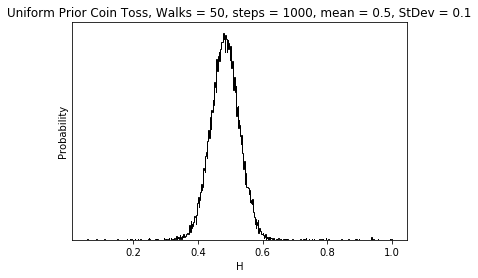

In [19]:
gctMC(50, ctn, cth, 1000, 0.5, 0.1)

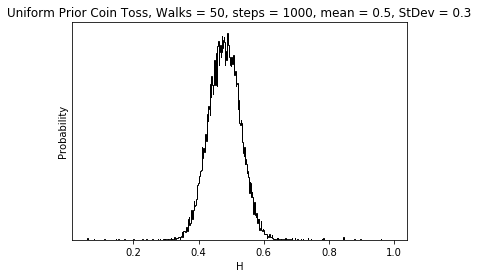

In [20]:
gctMC(50, ctn, cth, 1000, 0.5, 0.3)

In [21]:
gctMC(50, ctn, cth, 1000, 0.2, 0.1)

In [22]:
gctMC(50, ctn, cth, 1000, 0.5, 0.01)

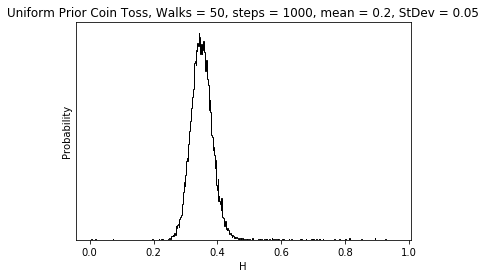

In [23]:
gctMC(50, ctn, cth, 1000, 0.2, 0.05)

In [24]:
gctMC(50, ctn, cth, 1000, 0.3, 0.01)

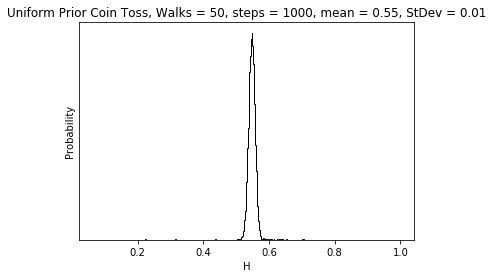

In [25]:
gctMC(50, ctn, cth, 1000, 0.55, 0.01)

As expected, changing the mean to be a few standard deviations away from the true value completely skews the distribution, as we observed in the last set. Lowering stdev makes the distribution more concentrated around a few values close to the mean, and shifting the mean shifts the distribution's center towards that value.

In [26]:
lights = lightdata(500, 1.0, 1.0)

lwt = 20 #light walks test
lipt = np.random.rand(lwt,2) #light initial point test

In [27]:
lt = emcee.EnsembleSampler(lwt, 2, loglightprob, args = [lights])
lttuple = lt.run_mcmc(lipt,100)
lt.reset()
dontprint2 = lt.run_mcmc(lipt,1000)

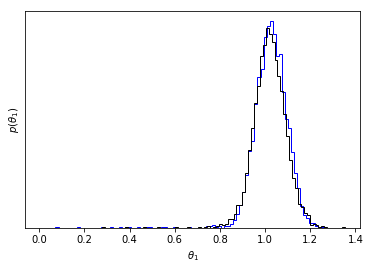

In [28]:
lightchain = lt.get_chain(flat=True)
plt.hist(lightchain[:, 0], 100, color="blue", histtype="step")
plt.hist(lightchain[:, 1], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [29]:
plt.hist2d(lightchain[:,0],lightchain[:,1], bins = 100)
plt.show()

Nice, that's roughly around (1,1), the "true" value of our lighthouse.

Okay, now that we've managed to make a 2d histogram for the lighthouse problem, time to make a function for it:

In [30]:
def lightxy(walks, steps, data):
    
    xy0 = np.random.rand(walks,2) #light initial points
    
    lightbase = emcee.EnsembleSampler(walks, 2, loglightprob, args = [data])
    lightbase.run_mcmc(xy0,100) 
    lightbase.reset()
    lightbase.run_mcmc(xy0,steps)
    
    lightchain = lightbase.get_chain(flat=True)
    
    lightplot = plt.figure(figsize = (20,5))
    lightplot.subplots_adjust(hspace = 0.3, wspace = 0.4)
    lightplot.suptitle("True (X, Y) = (1, 1), Walkers = " + str(walks) + ", Steps = " + str(steps))
    
    A = lightplot.add_subplot(1,3,1)
    B = lightplot.add_subplot(1,3,3)
    gram = lightplot.add_subplot(1,3,2)
    
    A.hist(lightchain[:, 0], 100, color="k", histtype="step")
    B.hist(lightchain[:, 1], 100, color="k", histtype="step")
    gram.hist2d(lightchain[:,0],lightchain[:,1], bins = 100)
    
    A.set_ylabel("Probability")
    A.set_xlabel("X location")
    A.set_title("X histogram")
    
    B.set_ylabel("Probability")
    B.set_xlabel("Y location")
    B.set_title("Y histogram")
    
    gram.set_ylabel("Y location")
    gram.set_xlabel("X location")
    gram.set_title("2D histogram")

Now to change the chain length:

Constant parameters: same data set, walkers = 50

Set of chain lengths used: (10, 50, 100, 1000, 10000)

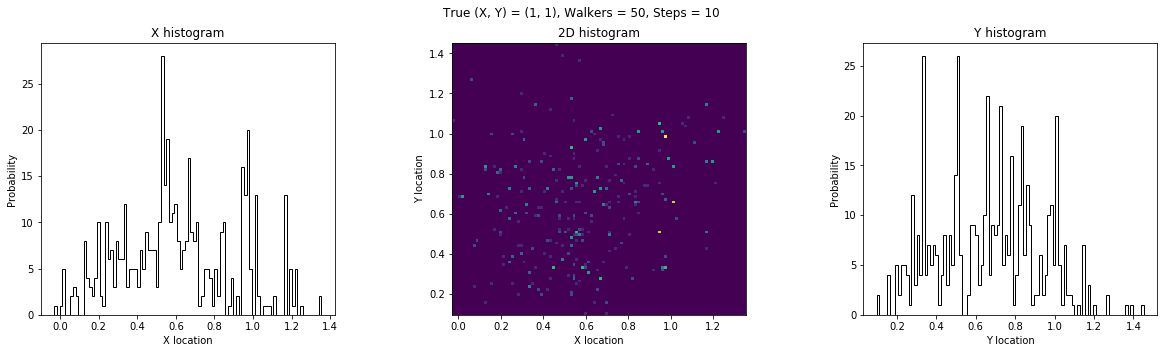

In [31]:
lightxy(50, 10, lights)

In [32]:
lightxy(50, 50, lights)

In [33]:
lightxy(50, 100, lights)

In [34]:
lightxy(50, 1000, lights)

In [35]:
lightxy(50, 10000, lights)

Now to vary number of chains:

Constant parameters: same data set, chain length = 100

Set of chain lengths used: (5, 10, 100, 1000)

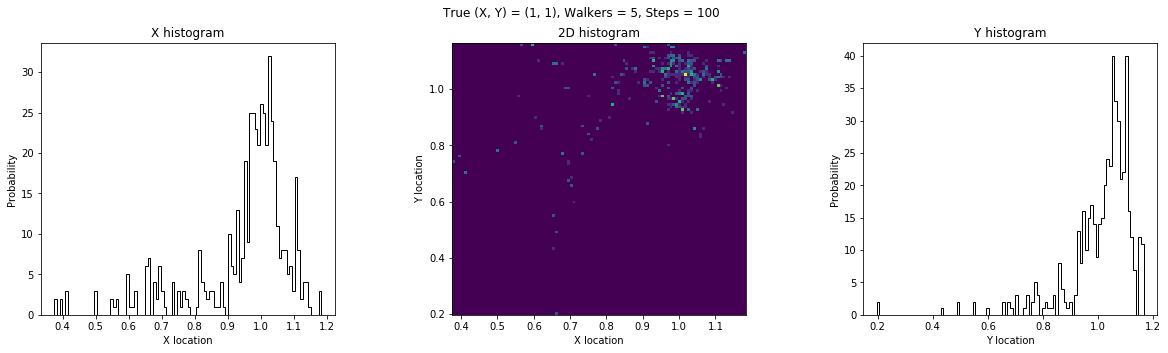

In [36]:
lightxy(5, 100, lights)

In [37]:
lightxy(10, 100, lights)

In [38]:
lightxy(100, 100, lights)

In [39]:
lightxy(1000, 100, lights)

As could be logically deduced, these plots show that both walkers and steps need to be sufficiently large such that the the estimate is close to the true value.

Now we want to find if there is any relationship between number of walks/steps and the prediction of each parameter value.

In [40]:
#gets the max probability x and y values

def lightmaxval(walks, steps, data):
    
    xy0 = np.random.rand(walks,2) #light initial points
    
    lightbase = emcee.EnsembleSampler(walks, 2, loglightprob, args = [data])
    lightbase.run_mcmc(xy0,100) 
    lightbase.reset()
    lightbase.run_mcmc(xy0,steps)
    
    lightchain = lightbase.get_chain(flat=True)
    
    lightprobs = lightbase.get_log_prob(flat=True)
    
    lightmaxindex = np.argmax(lightprobs)
    
    lightvals = lightchain[lightmaxindex]
    
    return(lightvals)

In [41]:
#plots the max x and y values for a given walks value and an array of step numbers

def lightstepplot(walks, stepsarray, data):
    
    xarray = []
    yarray = []
    
    for stepval in stepsarray:
        
        x, y = lightmaxval(walks, stepval, data)
        
        xarray.append(x)
        yarray.append(y)
    
    lightplot = plt.figure(figsize = (10,4))
    lightplot.subplots_adjust(hspace = 0.3, wspace = 0.4)
    lightplot.suptitle("Max probability X and Y values vs. number of steps with True (X, Y) = (1, 1), Walkers = " + str(walks))
    
    A = lightplot.add_subplot(1,2,1)
    B = lightplot.add_subplot(1,2,2)
    
    A.plot(stepsarray, xarray)
    A.set_xscale("log")
    
    B.plot(stepsarray, xarray)
    B.set_xscale("log")
    
    A.set_ylabel("X location")
    A.set_xlabel("Number of Steps")
    A.set_title("Max X Values")
    
    B.set_ylabel("Y location")
    B.set_xlabel("Number of Steps")
    B.set_title("Max Y Values")

In [42]:
stepvar = [5,10,50,100,500,1000,5000,10000]

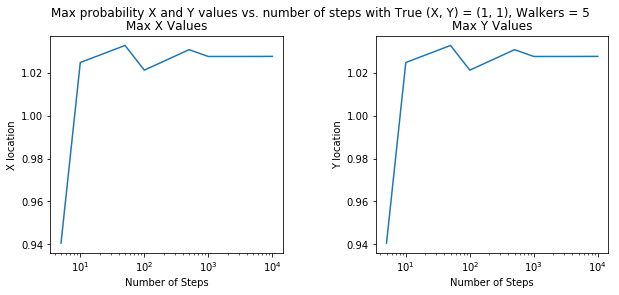

In [43]:
lightstepplot(5,stepvar,lights)

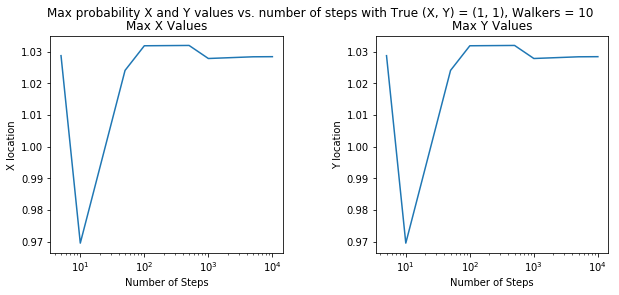

In [44]:
lightstepplot(10,stepvar,lights)

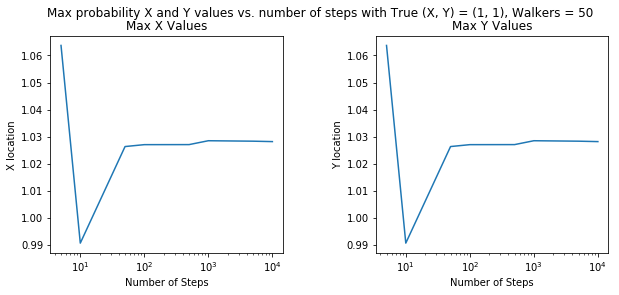

In [45]:
lightstepplot(50,stepvar,lights)

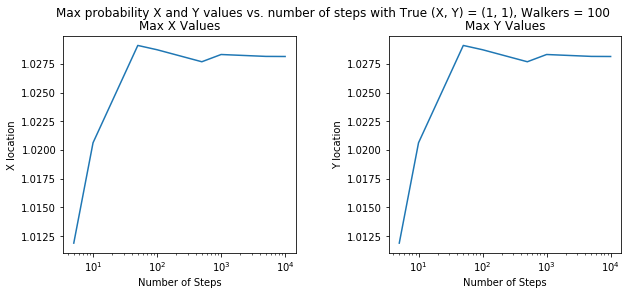

In [46]:
lightstepplot(100,stepvar,lights)

As could be predicted based on intuition, once there are sufficient trials such that sample bias doesn't push the prediction too far in either direction (which seems to be at around (steps * walks ~ 10^2 or 10^3), we can see that the number of steps doesn't significantly affect the prediction value.

To add a secondary light source, I'm going to run lightdata with different coordinate inputs and append that new list to the  original "lights" data set. Running that new compound data set thru the code above will show us how our distribution changes with the new light addition.

In [47]:
lights2 = lightdata(500, 2.0, 2.0)
totallights = np.append(lights,lights2)

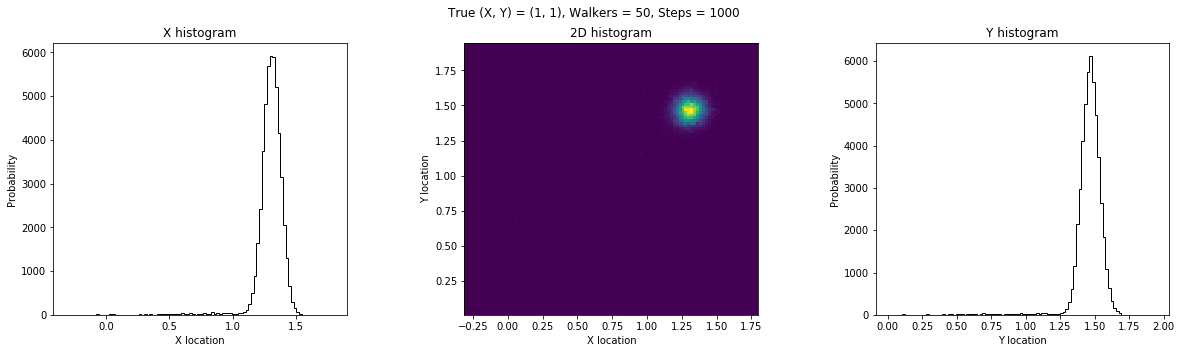

In [ ]:
lightxy(50,1000,totallights)

In [ ]:
lightxy(500,10000,totallights)

Even with many walkers and many steps, we don't see differentiation between the two light sources, we only see one peak that has been skewed. This is to be expected as the equations we have set up to detect the light source were not designed with two origin points in mind, so the algorithm is trying to make sense of the data within the context that there should only be one source point.